<a href="https://colab.research.google.com/github/keeratkaurbhatia/Melanoma-vs-Nevi-XAI-Analysis/blob/main/Calibre_final_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 stage training with increased epochs improved the quality of results MASSIVELY.

cosine annealing didn't make that much
of a difference, but it is recommended for modern deep learning tasks so i used it.


data augmentation reduced the quality of results by a bit, but it's an important process so idts it should be removed.

-keerat.


In [ ]:
#@title 1. Setup and Environment Configuration
#required libraries
!pip install -q tensorflow opencv-python #q flag so no output (quiet)

import os #for directories
import zipfile #for zip files
import numpy as np #for arrays
import pandas as pd #for data manipulation
import matplotlib.pyplot as plt #for plots/visualisations
import cv2  #for image processing


import tensorflow as tf #for building, training the model
from tensorflow.keras.applications import EfficientNetB3 #pre-trained cnn model (transfer-learning)
from tensorflow.keras.models import Model #model definitions- for classification head
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout #for 3d tensor to 1d vector, fully connected layers (sigmoid for binary classification), and regularisation, respectively.
from tensorflow.keras.optimizers import Adam #updates weights to minimise loss
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #for saving the best version, preventing overfitting, respectively.

from sklearn.model_selection import train_test_split #for splitting the dataset
from sklearn.metrics import classification_report, confusion_matrix #for evaluation

print("TensorFlow Version:", tf.__version__)
print("Setup Complete")

TensorFlow Version: 2.19.0
Setup Complete


In [ ]:
#@title 2. Preparing Dataset
#kaggle api for dataset download
print("Upload the 'kaggle.json' file.")
from google.colab import files
if not os.path.exists('/root/.kaggle/kaggle.json'): #if file isn't uploaded
    files.upload() #dialog box for uploading
    !mkdir -p ~/.kaggle #creates directory (-p=parent)
    !cp kaggle.json ~/.kaggle/ #copies file to the new kaggle directory
    !chmod 600 ~/.kaggle/kaggle.json #changes permission to be readable, writable by owner only.

#downloading and unzipping the HAM10000 dataset
if not os.path.exists('ham10000_data'): #if dataset isn't already downloaded
    print("\nDownloading HAM10000 dataset.")
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 #uses the above api to download it
    print("Unzipping dataset.")
    with zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
        zip_ref.extractall('ham10000_data')
else:
    print("Dataset already downloaded.")

print("Dataset Ready")

Upload the 'kaggle.json' file.


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [02:26<00:00, 75.1MB/s]
100% 5.20G/5.20G [02:26<00:00, 38.1MB/s]
Unzipping dataset.
Dataset Ready


In [3]:
#@title 3. Image Preprocessing
#parameters
GAMMA = 1.2 #for increasing the saturation, so that the pigmentation is visible.
CONTRAST_LOWER_PERCENTILE = 2.0 #to normalise poor lighting, pixels darker than this bound would be set to black
CONTRAST_UPPER_PERCENTILE = 98.0 #pixels lighter than this bound would be set to white
CLAHE_CLIP_LIMIT = 2.0 #how much contrast is to be amplified in a tile. this would enhance relevant features without making noise prominent.
CLAHE_GRID_SIZE = (8, 8) #defines image into a 8x8 grid

def apply_clahe(image):
    #improves local contrast, so that the relevant features are visible, like lesion borders and textures.
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) #rgb to lab (l=light, color(a,b)) so contrast can be adjusted w/o distorting colors.
    l, a, b = cv2.split(lab) #splitting into separate channels
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_GRID_SIZE) #clahe object
    cl = clahe.apply(l) #only applied to lightness channel
    limg = cv2.merge((cl, a, b)) #merging enhanced lightness channel with original colors
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB) #back to rgb model
    return final

def apply_contrast_stretching(image):
    lp, hp = np.percentile(image, (CONTRAST_LOWER_PERCENTILE, CONTRAST_UPPER_PERCENTILE))
    if hp - lp < 1e-8:
        return image.astype(np.uint8)
    stretched = np.clip(255 * (image - lp) / (hp - lp), 0, 255).astype(np.uint8)
    return stretched

def apply_gamma_correction(image, gamma=GAMMA):
    #to reveal color variations/better saturation
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8") #maps pixels to their corrected gamma values in a lookup table
    return cv2.LUT(image, table) #applies gamma correction

def preprocess_pipeline(image):
    #full chain of preprocessing steps.
    #converting tensorflow tensor to np array (because of opencv)
    image_np = image.numpy()
    image_np = apply_clahe(image_np)
    image_np = apply_contrast_stretching(image_np)
    image_np = apply_gamma_correction(image_np)
    #converting back to tensor so it can be used
    return tf.convert_to_tensor(image_np, dtype=tf.uint8)

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [4]:
#@title 4. TensorFlow Data Pipeline
from tensorflow.keras.applications.efficientnet import preprocess_input
#constants
IMAGE_SIZE = (300, 300) #required input size for efficientnetb3
BATCH_SIZE = 16
TARGET_CLASSES = ['nv', 'mel'] #'nv' (benign nevi) and 'mel' (malignant melanoma). so a binary problem.

#metadata
base_dir = 'ham10000_data'
df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv')) #loads metadata into a df

#a dictionary that maps each 'image_id' from the csv to its actual file path on the disk.
image_paths = {os.path.splitext(f)[0]: os.path.join(base_dir, folder, f)
               for folder in ['ham10000_images_part_1', 'ham10000_images_part_2'] #images are in 2 folders
               for f in os.listdir(os.path.join(base_dir, folder))}
df['path'] = df['image_id'].map(image_paths.get) #new column of full file path

#filter for binary classification, discards other lesion types
df_filtered = df[df['dx'].isin(TARGET_CLASSES)].copy()

#undersampling, after seeing the filtered date, nv is the majority class
df_majority = df_filtered[df_filtered['dx'] == 'nv']
df_minority = df_filtered[df_filtered['dx'] == 'mel']
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42) #random_state for reproducability
df_balanced = pd.concat([df_majority_undersampled, df_minority]) #final balanced df

#binary labels- 0 for nv, 1 for mel
df_balanced['label'] = df_balanced['dx'].apply(lambda x: 1 if x == 'mel' else 0)

#data splitting (80/10/10)=(train/validation/test)
train_df, test_val_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']) #stratify so that the 50/50 proportion b/w nv and mel is maintained in both the sets
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['label']) #splitting the above 20% into 10-10%

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

#pipeline functions
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.uint8)

    image = tf.py_function(func=preprocess_pipeline, inp=[image], Tout=tf.uint8)
    image.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)

    return image, label

    # 2. preprocessing
    image = tf.py_function(func=preprocess_pipeline, inp=[image], Tout=tf.uint8) #allows to use python/opencv code inside tensorflow
    # tf.py_function does not preserve shape information, setting it manually
    image.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3]) #(300x300) as defined above, and 3 for the rgb channels


    # 3. final model preparation
    image = tf.cast(image, tf.float32) #float for model input

    return image, label

def build_dataset(df, shuffle=False):
    #tf.data.Dataset from df
    ds = tf.data.Dataset.from_tensor_slices((df['path'].values, df['label'].values))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) #loading and preprocessing functions applied, autotune for processing images parallely
    if shuffle: #in training, shuffling the dataset in each epoch to generalise better
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE) #batches
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE) #optimisation, prepares next batch of data while the current one is being worked upon
    return ds

#creating datasets
train_ds = build_dataset(train_df, shuffle=True)
val_ds = build_dataset(val_df)
test_ds = build_dataset(test_df)

print("\n `tf.data` pipelines created successfully.")

Training set: 1780 samples
Validation set: 223 samples
Test set: 223 samples

 `tf.data` pipelines created successfully.


Displaying a corrected sample of the preprocessing pipeline:


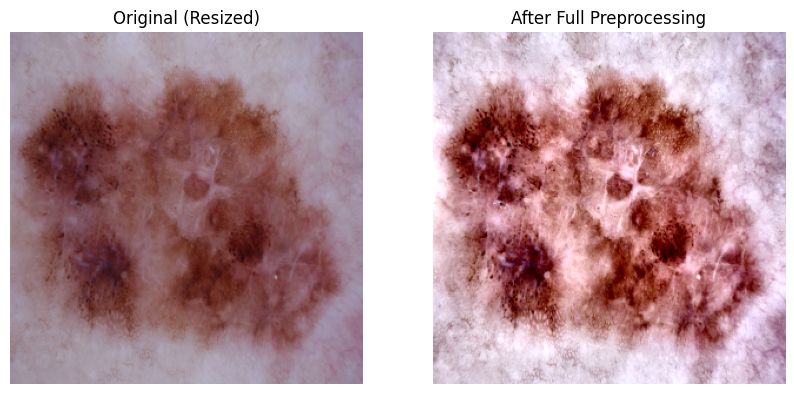

In [5]:
#@title 5. Visualize Preprocessing Effects



def visualize_preprocessing_corrected(df):

    # 1. select a specific image to visualize from the dataframe
    sample_row = df.iloc[0] # using the first image for consistency
    sample_path = sample_row['path']
    sample_label = sample_row['label']

    # 2. create the "original" version (just load and resize)
    original_img_tensor = tf.io.read_file(sample_path)
    original_img_tensor = tf.image.decode_jpeg(original_img_tensor, channels=3)
    original_img = tf.image.resize(original_img_tensor, IMAGE_SIZE).numpy().astype('uint8')

    # 3. create the "Preprocessed" version by running the same image through the pipeline
    preprocessed_img_tensor, _ = load_and_preprocess_image(sample_path, sample_label)
    preprocessed_img = preprocessed_img_tensor.numpy().astype('uint8')

    # 4. plot the direct comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original (Resized)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_img)
    plt.title("After Full Preprocessing")
    plt.axis('off')
    plt.show()

print("Displaying a corrected sample of the preprocessing pipeline:")
visualize_preprocessing_corrected(train_df)

In [6]:
#@title 6. Building and Compiling EfficientNetB3 Model

#layers needed for data augmentation
from tensorflow.keras import layers

base_model = EfficientNetB3(
    weights='imagenet', #pre-trained
    include_top=False, #as the original layer was for classifying 1000 different objects, which isn't needed by us
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

#custom classification head
#it will apply random transformations to the images only during training.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
], name="data_augmentation")

inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
#passing the augmented images as the input to the base model.
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x) #deactivates 40% neurons
outputs = Dense(1, activation='sigmoid')(x) #binary classification

model = Model(inputs=inputs, outputs=outputs) #new model compiling the pre-trained base and the custom head

#callbacks
MODEL_PATH = "best_efficientnetb3_model.keras"
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1) #monitoring on the basis of validation accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True, verbose=1) #if loss doesn't improve for 10 (patience) epochs, training will be stopped to prevent the model from getting worse
#verbose for printing progress updates

print("Model built.")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built.


In [7]:
#@title 7. Two-Stage Model Training with Cosine Annealing

#stage 1- feature extraction with cosine annealing, basically to "warm-up" the layers
print("STAGE 1: Training the classification head.")
base_model.trainable = False #freeze the base model. the goal is to train the custom head we've added, so that the pre-trained weights aren't corrupted

#1. the cosine annealing schedule
#this smoothly decreases the learning rate over the training period, following a cosine curve. this is better for convergence than a fixed learning rate/stepped reductions
epochs_stage1 = 20
steps_per_epoch = len(train_df) // BATCH_SIZE
decay_steps = steps_per_epoch * epochs_stage1 #number of steps required by the scheduler

#import for cosinedecay
from tensorflow.keras.optimizers.schedules import CosineDecay

cosine_decay_scheduler = CosineDecay(
    initial_learning_rate=1e-3, # starting learning rate (which is high initially)
    decay_steps=decay_steps,
    alpha=0.0 # minimum learning rate at the end
)

#2. compiling the model with the new scheduler
model.compile(
    optimizer=Adam(learning_rate=cosine_decay_scheduler), #adam is used, but instead of a fixed number for the learning rate, we are using the scheduler
    loss='binary_crossentropy', #standard loss function for binary classification
    metrics=['accuracy'] #accuracy tracking during training
)

#3. training the model
# re-defining callbacks without reducelronplateau (initially tried that only, this time checking if cosine annealing would yield better result)
MODEL_PATH = "best_efficientnetb3_model.keras"
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=1)

#beginning with stage 1 training
history_stage1 = model.fit(
    train_ds,
    epochs=epochs_stage1,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)


#stage 2: fine tuning
#now head is trained, we unfreeze the model and continue with a very low learning rate
print("\nSTAGE 2: Fine-tuning the entire model.")
base_model.trainable = True

# re-compile with a fixed low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), #small, careful adjustment
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#continue stage 2 training
history_stage2 = model.fit(
    train_ds,
    epochs=40, # target total epochs for this stage
    initial_epoch=history_stage1.epoch[-1], #to continue the epoch count from where stage 1 left off
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

print("Training complete.")

STAGE 1: Training the classification head.
Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6421 - loss: 0.6285
Epoch 1: val_accuracy improved from -inf to 0.77130, saving model to best_efficientnetb3_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.6426 - loss: 0.6279 - val_accuracy: 0.7713 - val_loss: 0.5053
Epoch 2/20
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7459 - loss: 0.4913
Epoch 2: val_accuracy did not improve from 0.77130
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.7462 - loss: 0.4910 - val_accuracy: 0.7668 - val_loss: 0.4718
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7867 - loss: 0.4605
Epoch 3: val_accuracy improved from 0.77130 to 0.78475, saving model to best_efficientnetb3_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.7868 - loss: 0.4604 - val_accuracy: 0.7848 - val_loss: 0.4669
Epoch 4/20
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7795 - lo

In [8]:
#@title 8. Find Optimal Threshold Using Validation Set
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

#loading the best model saved by the checkpoint
print("Loading best model from checkpoint.")
best_model = load_model('/content/best_efficientnetb3_model.keras')

def find_optimal_threshold(model, val_ds):
    """Find optimal classification threshold using validation set for better performance"""
    print("Finding optimal classification threshold...")
    y_true = []
    y_pred_probs = []

    # get true labels and predicted probabilities from validation set
    for images, labels in val_ds:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0))

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs).flatten()

    # try different thresholds to find the best one
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_pred_probs > threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Optimal threshold: {best_threshold:.3f} (F1-score: {best_f1:.3f})")
    return best_threshold

# find the optimal threshold using validation set
optimal_threshold = find_optimal_threshold(best_model, val_ds)

Loading best model from checkpoint.
Finding optimal classification threshold...
Optimal threshold: 0.400 (F1-score: 0.828)


Loading best model from checkpoint.

Evaluating model performance on the test set.
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.7526 - loss: 0.4721
Test Loss: 0.4679
Test Accuracy: 0.7534

Classification Report:
              precision    recall  f1-score   support

    Nevi (0)       0.88      0.63      0.74       112
Melanoma (1)       0.71      0.91      0.80       111

    accuracy                           0.77       223
   macro avg       0.79      0.77      0.77       223
weighted avg       0.79      0.77      0.77       223



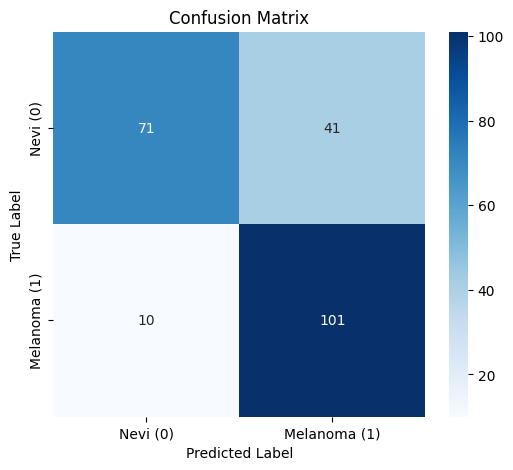

In [9]:
#@title 9. Evaluation of the Test Set
from tensorflow.keras.models import load_model

#loading the best model saved by the checkpoint
print("Loading best model from checkpoint.")
best_model = load_model('/content/best_efficientnetb3_model.keras')

# evaluate on the test set
print("\nEvaluating model performance on the test set.")
results = best_model.evaluate(test_ds, return_dict=True)
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")

#classification report and confusion matrix
y_true = []
y_pred_probs = []

# true labels and predicted probabilities from the test set
for images, labels in test_ds:
    y_true.extend(labels.numpy()) #stores true labels (0,1)
    y_pred_probs.extend(best_model.predict(images, verbose=0)) #raw probabilities

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs).flatten()
y_pred = (y_pred_probs > optimal_threshold).astype(int) #true to this condition = 1 and vice versa

# classification report
print("\nClassification Report:")
class_names = ['Nevi (0)', 'Melanoma (1)']
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 10 XAI Implementation

In [10]:
# aahh so many linraries reqd for my boi xai
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom
from skimage.segmentation import mark_boundaries
import warnings
warnings.filterwarnings('ignore')

# For saving results - galti sirf ek baar hoti hai
import os
from datetime import datetime
import json

corrected xai implementation, the analysis code remains the same as before.

-keerat.

In [11]:
#@title 10.1 Gradient-based XAI Methods

class GradientXAI:
    """these methods help to understand which pixels in the input image
    influences the model's prediction the most, by looking at the gradient of the
    model's output wrt the input"""

    def __init__(self, model):
        self.model = model #keep a reference to the trained model we are to explain

    @tf.function(reduce_retracing=True) #tf function to make running faster, reduce_retracing to avoid rebuilding the tf graph if inputs with same shape/type
    def compute_gradients(self, images):
        """compute the gradients of the prediction score with
        respect to the pixels in the image.
        gradient = delta (model output)/ delta (input pixels)"""

        images = tf.convert_to_tensor(images, dtype=tf.float32) #ensure tf tensor and correct datatype

        with tf.GradientTape() as tape:
            tape.watch(images) #tell tf to record operations on the input so we can differentiate wrt the image
            predictions = self.model(images, training=False)  #inference mode, stable. no dropout, training updates
            #logits instead of probabilities to avoid saturation issues- near zero gradients
            if predictions.shape[-1] == 1: #binary classification
              p = tf.clip_by_value(predictions, 1e-6, 1.0 - 1e-6) #forcing values to not be exactly equal to 0/1, else logp,1/p would blow up
              target_score = tf.math.log(p / (1.0 - p)) #sigmoid output back to logits
            #else: if softmax was used in place of sigmoid
              #idx = tf.argmax(predictions[0]) #pick most probable class for this sample
              #target_score = predictions[:, idx] #class score to attribute
        gradients = tape.gradient(target_score, images) #how much changing each pixel changes the score
        if gradients is None:
          print("Warning: Gradients are None, creating zero gradients")
          gradients = tf.zeros_like(images)

            # Check for NaN/Inf values
          gradients = tf.where(tf.math.is_finite(gradients), gradients, tf.zeros_like(gradients))

        return gradients, predictions

    def vanilla_gradients(self, image):
        """raw gradient magnitude, shows which pixels most affect the class score"""
        #ensure image is float32 and normalized
        if image.dtype != tf.float32:
            image = tf.cast(image, tf.float32)
        image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
        image_batch = tf.expand_dims(image, 0) #batchify the one image for the model
        gradients, _ = self.compute_gradients(image_batch) #get gradients for this single image

        if gradients is None:
            print("Warning: Gradients are None - check model architecture")
            return np.zeros(image.shape[:2], dtype=np.float32)

        gradients = tf.abs(gradients[0]) #absolute value, we care only about strength/magnitude
        gradients = tf.reduce_max(gradients, axis=-1) #rgb to single heatmap- 2D/grayscale

        return gradients.numpy() #feed into plotting

    def integrated_gradients(self, image, steps=100):
        """insead of looking at one gradient, we'll average gradients along a path from a baseline
        black image to the actual one. it'll reduce noise and capture important pixels better."""
        if image.dtype != tf.float32:
            image = tf.cast(image, tf.float32)

        image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))

        image_batch = tf.expand_dims(image, 0)


        baselines = [tf.zeros_like(image_batch),
    tf.ones_like(image_batch),
    tf.ones_like(image_batch) * 0.5  ]



        #interpolation steps from baseline to image, like in-between images
        alphas = tf.linspace(0.0, 1.0, steps + 1)
        total_scaled_grads = tf.zeros_like(image_batch[0])



        for base in baselines:
          baseline_grads = tf.zeros_like(image_batch[0])
          for alpha in alphas:
            interpolated = base + alpha * (image_batch - base)
            gradients, _ = self.compute_gradients(interpolated)
            if gradients is not None:
              baseline_grads += gradients[0]
          baseline_grads = baseline_grads / float(len(alphas))
          scaled_grads = (image_batch[0] - base[0]) * baseline_grads
          total_scaled_grads += scaled_grads
        integrated_grads = total_scaled_grads / float(len(baselines))

        #averaging gradients over all steps (approximating the integral)

        integrated_grads = tf.abs(integrated_grads)
        integrated_grads = tf.reduce_max(integrated_grads, axis=-1)

        result = integrated_grads.numpy()
        result = np.where(np.isfinite(result), result, 0.0)

        if result.max() > result.min():
          result = (result - result.min()) / (result.max() - result.min())

        return result.astype(np.float32)

    def smoothgrad(self, image, n_samples=50, noise_level=0.10):
      """vanilla gradients can be noisy, smoothgrad adds small random noise to image many times,
      gradients each time, and averages them. this keeps consistent signal, while reducing noise"""
      if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)
      image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
      image_batch = tf.expand_dims(image, 0)
      acc = tf.zeros_like(image_batch, dtype=tf.float32) #accumulator for squared gradients

      #repetition with noise
      for _ in range(n_samples):
        noise = tf.random.normal(image_batch.shape, stddev=noise_level, dtype=tf.float32)
        noisy_image = image_batch + noise
        gradients, _ = self.compute_gradients(noisy_image)
        if gradients is not None:
            acc += tf.square(tf.cast(gradients, tf.float32))

      sm = acc / float(n_samples) #average
      sm = tf.reduce_mean(sm[0], axis=-1)  #reduce to grayscale
      heat = sm.numpy()
      heat = np.where(np.isfinite(heat), heat, 0.0)
      heat = cv2.GaussianBlur(heat.astype(np.float32), (3, 3), 0)
      mn, mx = heat.min(), heat.max() #normalise between 0 and 1
      return ((heat - mn) / (mx - mn + 1e-8)).astype(np.float32)

In [12]:
#@title 10.2 GradCAM

class GradCAM:
    def __init__(self, model, last_conv_name="efficientnetb3/top_conv"):
        self.model = model
        #extracting our main feature extractor, efficientnetb3
        self.base = self.model.get_layer("efficientnetb3")

        if "/" in last_conv_name:
            _, name = last_conv_name.split("/", 1) #in the last_conv_layer, removing the part before /, like abc/def to def
        else:
            name = last_conv_name
        self.last_conv_layer = self.base.get_layer(name)  #getting the top conv layer
        self._build_grad_model() #helper model, gives feature maps and predictions
        print(f"GradCAM using layer: {self.last_conv_layer.name} {self.last_conv_layer.output.shape}")

    def _build_grad_model(self):
        base_inp = self.base.input #input to the base cnn
        conv_maps = self.last_conv_layer.output  #output of the last convolutional layer, shape (H,W,C)
        x = self.base.output #starting from the base and rebuilding the top layers
        #we are doing so as if we just cal model, we'll only get preds and for base, we'll only get feature maps. we need both.
        x = self.model.get_layer('global_average_pooling2d')(x)
        try:
            x = self.model.get_layer('dropout')(x, training=False) #training is false, so it doesn't drop features now
        except Exception:
            pass
        preds = self.model.get_layer('dense')(x) #fully connected layer for classification
        self.grad_model = tf.keras.Model(inputs=base_inp, outputs=[conv_maps, preds]) #helper model

    def _preprocess_like_training(self, image_uint8):
        x = preprocess_pipeline(tf.convert_to_tensor(image_uint8, tf.uint8))  #our opencv chain
        x = tf.cast(x, tf.float32) #pixels to float
        x = preprocess_input(x) #normalisation
        return x[None, ...] #addinng a "batch" dimension, otherwise shape error. because the model expects batches

    def generate_heatmap(self, image_uint8, pred_index=None, plus_plus=False):
        x = self._preprocess_like_training(image_uint8) #preprocessing
        with tf.GradientTape() as tape: #recording everything so gradients can be computed later
            conv, preds = self.grad_model(x, training=False) #running image through the grad model
            if preds.shape[-1] == 1: #binary classification
                p = tf.clip_by_value(preds, 1e-6, 1-1e-6) #not exactly 0,1. they can cause calculation errors.
                score = tf.math.log(p / (1.0 - p))[:, 0] #logit formula

            #else: multiclass logic (not concerned to us)
                #idx = tf.argmax(preds, axis=-1) if pred_index is None \
                      #else tf.fill([tf.shape(preds)[0]], int(pred_index))
                #score = tf.gather(preds, idx, axis=1, batch_dims=1)

        grads = tape.gradient(score, conv) #find gradient
        conv0, grads0 = conv[0], grads[0] #remove batch dimension for easy handling

        if not plus_plus: #classic gradcam, avg gradient of each channel
            weights = tf.reduce_mean(grads0, axis=(0, 1))
        else: #gradcam++
            eps = 1e-8
            relu_grads = tf.nn.relu(grads0) #only positive gradients
            g2 = tf.square(grads0) #squared gradients
            g3 = g2 * grads0 #cubed
            sum_c_g3 = tf.reduce_sum(conv0 * g3, axis=(0, 1))
            #conv0= (H,W,C). multiplied with cubed gradients, and from the axis it is summed over the h,w channels
            alpha = g2 / (2.0 * g2 + sum_c_g3 + eps) #formula
            weights = tf.reduce_sum(alpha * relu_grads, axis=(0, 1))

        cam = tf.reduce_sum(conv0 * weights[None, None, :], axis=-1) #summation of feature map * importance
        cam = tf.nn.relu(cam) #only positive values, areas that help in prediction
        cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + 1e-8) #normalisation between 0 and 1
        return cam.numpy().astype("float32") #np for visualisation

In [13]:
#@title 10.3 LIME
class LIME:

    def __init__(self, model):
        self.model = model #storing the model
        #its model agnostic, so we need not know the internal workings

    def generate_superpixels(self, image, n_segments=100):
      from skimage.segmentation import slic
      img_np = image.numpy().astype('uint8') if isinstance(image, tf.Tensor) else np.asarray(image, dtype='uint8')
      #this divides image into segments/superpixels
      segments = slic(img_np, n_segments=n_segments, compactness=10, sigma=1, channel_axis=-1)
      return segments

    def explain(self, image, num_samples=1000, num_features=10):

        from tensorflow.keras.applications.efficientnet import preprocess_input
        from sklearn.linear_model import Ridge

        #generate superpixels
        segments = self.generate_superpixels(image)

        #random masks, 1 keeps the superpixel visible. and 0 blacks it out.
        num_superpixels = np.unique(segments).shape[0]
        masks = np.random.randint(0, 2, size=(num_samples, num_superpixels))

        predictions = []
        for mask in masks: #each mask is perturbed version
            perturbed = image.numpy().copy()
            for i, val in enumerate(mask):
                if val == 0:
                    perturbed[segments == i] = 0

            perturbed = tf.convert_to_tensor(perturbed, dtype=tf.float32)
            perturbed = preprocess_input(tf.expand_dims(perturbed, 0)) #normalisaton+batchifying

            pred = self.model.predict(perturbed, verbose=0) #predictions stored for each perturbed sample
            predictions.append(pred[0, 0])

        predictions = np.array(predictions)

        #a linear model to check how similar to original image
        #more similar masks will get higher weights
        distances = np.sum(masks, axis=1) / num_superpixels
        weights = np.exp(-distances)
        model = Ridge(alpha=1.0)
        model.fit(masks, predictions, sample_weight=weights)

        #feature importance/coefficients
        importance = model.coef_

        #assigning coeffs back to pixel, to create an importance map
        heatmap = np.zeros_like(segments, dtype=float)
        for i, imp in enumerate(importance):
            heatmap[segments == i] = imp

        #normalising for visualisation
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        return heatmap

In [14]:
#@title 10.4 SHAP
class SHAP:

    def __init__(self, model):
        self.model = model

    def deep_explain(self, image, background_samples=50):
      from tensorflow.keras.applications.efficientnet import preprocess_input

      image = tf.expand_dims(image, 0) #batchifying
      image = preprocess_input(tf.cast(image, tf.float32)) #normalisation
      #background image
      background = tf.zeros((background_samples,) + image.shape[1:], dtype=tf.float32)

      attributions = [] #store gradient results
      steps = 50 #interpolation steps from bg to image

      #gradually blend bg into the actual image
      for i in range(steps):
        alpha = i / steps #how far the blend is in
        #in between image between og and bg
        interpolated = background[0:1] + alpha * (image - background[0:1])
        with tf.GradientTape() as tape:
            tape.watch(interpolated) #track changes to pixels
            pred = self.model(interpolated, training=False)
            if pred.shape[-1] == 1: #binary classification
                p = tf.clip_by_value(pred, 1e-6, 1 - 1e-6)
                score = tf.math.log(p / (1.0 - p))[:, 0]
            #else: multi class logic, not applicable here
                #idx = tf.argmax(pred[0])
                #score = pred[:, idx]
        grads = tape.gradient(score, interpolated)
        attributions.append(grads) #for avg later

      attributions = tf.reduce_mean(tf.stack(attributions), axis=0) #avg
      attributions = (image - background[0:1]) * attributions #shap style atribution- actual contributions
      heatmap = tf.reduce_sum(tf.abs(attributions[0]), axis=-1) #absolute contributions  across color channels, summed
      heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8) #normalise
      return heatmap.numpy()

In [15]:
#@title 10.5 Occlusion Sensitivity
class OcclusionSensitivity:

    def __init__(self, model):
        self.model = model

    def explain(self, image, patch_size=60, stride=30):
      from tensorflow.keras.applications.efficientnet import preprocess_input

      h, w = image.shape[:2] #height, widthg
      acc = np.zeros((h, w), dtype=np.float32) #accumulation, how much each pixel affects the preds
      cnt = np.zeros((h, w), dtype=np.float32) #how many time pixel under covered patch

      img_proc = preprocess_input(tf.expand_dims(tf.cast(image, tf.float32), 0))
      baseline_pred = float(self.model.predict(img_proc, verbose=0).reshape(-1)[0]) #baseline predictions, reference point

      for i in range(0, h - patch_size + 1, stride): #stride- how far the patch moves in each step
        for j in range(0, w - patch_size + 1, stride):
            #copy of the image
            occluded = image.numpy().copy() if isinstance(image, tf.Tensor) else np.array(image, copy=True)
            occluded[i:i+patch_size, j:j+patch_size] = 0 #selected patch covered with zeros
            occluded_proc = preprocess_input(tf.expand_dims(tf.cast(occluded, tf.float32), 0))
            pred = float(self.model.predict(occluded_proc, verbose=0).reshape(-1)[0])
            diff = abs(pred - baseline_pred) #how much the prediction changed
            acc[i:i+patch_size, j:j+patch_size] += diff #each pixel gets diff added to its importance
            cnt[i:i+patch_size, j:j+patch_size] += 1.0 #how many patches covered each pixel

      sensitivity_map = np.divide(acc, cnt, out=np.zeros_like(acc), where=cnt > 0) #avg the importance per pixel, ie acc/cnt
      if sensitivity_map.max() > 0:
        sensitivity_map /= sensitivity_map.max() #normalise
      return sensitivity_map

In [16]:
#@title Consistency Metrics
class ConsistencyAnalyzer:
    """Analyze consistency between different XAI methods"""

    @staticmethod
    def compute_similarity_metrics(heatmap1, heatmap2):
        """Compute various similarity metrics between two heatmaps"""
        from scipy.stats import pearsonr, spearmanr
        from skimage.metrics import structural_similarity
        from skimage.transform import resize

        # Ensure float type
        heatmap1 = np.array(heatmap1, dtype=np.float32)
        heatmap2 = np.array(heatmap2, dtype=np.float32)
        heatmap1 = np.where(np.isfinite(heatmap1), heatmap1, 0.0)
        heatmap2 = np.where(np.isfinite(heatmap2), heatmap2, 0.0)

        # Resize heatmaps to match
        if heatmap1.shape != heatmap2.shape:
            heatmap2 = resize(heatmap2, heatmap1.shape, mode='reflect', anti_aliasing=True)
            heatmap2 = np.where(np.isfinite(heatmap2), heatmap2, 0.0)
        # Normalize to [0, 1]
        def safe_normalize(arr):
          arr_min, arr_max = arr.min(), arr.max()
          if arr_max > arr_min:
            return (arr - arr_min) / (arr_max - arr_min)
          else:
            return np.zeros_like(arr)

        h1_norm = safe_normalize(heatmap1)
        h2_norm = safe_normalize(heatmap2)

        # Flatten for correlation
        h1_flat = h1_norm.flatten()
        h2_flat = h2_norm.flatten()

        valid_mask = np.isfinite(h1_flat) & np.isfinite(h2_flat)
        if np.sum(valid_mask) < 2:  # Not enough valid data
          return {
                    'pearson': 0.0,
                    'spearman': 0.0,
                    'ssim': 0.0,
                    'iou_top20': 0.0
                }

        h1_clean = h1_flat[valid_mask]
        h2_clean = h2_flat[valid_mask]

        try:
          pearson_corr, _ = pearsonr(h1_clean, h2_clean)
          pearson_corr = pearson_corr if np.isfinite(pearson_corr) else 0.0
        except:
          pearson_corr = 0.0

        try:
          spearman_corr, _ = spearmanr(h1_clean, h2_clean)
          spearman_corr = spearman_corr if np.isfinite(spearman_corr) else 0.0
        except:
          spearman_corr = 0.0

        # SSIM (Structural Similarity)
        try:
          ssim = structural_similarity(h1_norm, h2_norm, data_range=1.0)
          ssim = ssim if np.isfinite(ssim) else 0.0
        except:
          ssim = 0.0

        # IoU for top 20% pixels
        try:
          threshold1 = np.percentile(h1_norm, 80)
          threshold2 = np.percentile(h2_norm, 80)
          mask1 = h1_norm > threshold1
          mask2 = h2_norm > threshold2
          intersection = np.logical_and(mask1, mask2).sum()
          union = np.logical_or(mask1, mask2).sum()
          iou = intersection / (union + 1e-8) if union > 0 else 0.0
          iou = iou if np.isfinite(iou) else 0.0
        except:
          iou = 0.0

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'ssim': ssim,
            'iou_top20': iou
        }

    @staticmethod
    def analyze_consistency(results_list):
      method_names = sorted(list({
        k
        for r in results_list
        if isinstance(r, dict) and isinstance(r.get('methods'), dict)
        for k in r['methods'].keys()
      }))
      if not method_names:
        raise ValueError("No heatmaps available for consistency analysis.")
      n_methods = len(method_names)

      consistency_matrices = {
        'pearson': np.eye(n_methods, n_methods, dtype=np.float32),
        'spearman': np.eye(n_methods, n_methods, dtype=np.float32),
        'ssim': np.eye(n_methods, n_methods, dtype=np.float32),
        'iou_top20': np.eye(n_methods, n_methods, dtype=np.float32)
    }

      for i in range(n_methods):
        for j in range(i+1, n_methods):
            similarities = []
            for result in results_list:
                m_i = result['methods'].get(method_names[i])
                m_j = result['methods'].get(method_names[j])
                if m_i is None or m_j is None:
                    continue
                sim = ConsistencyAnalyzer.compute_similarity_metrics(m_i, m_j)
                similarities.append(sim)

            if similarities:
                        # Average the similarities
              for metric in consistency_matrices:
                avg_sim = np.mean([s[metric] for s in similarities])
                            # Ensure finite value
                avg_sim = avg_sim if np.isfinite(avg_sim) else 0.0
                consistency_matrices[metric][i, j] = avg_sim
                consistency_matrices[metric][j, i] = avg_sim  # Symmetric
            else:
                        # No valid comparisons
              for metric in consistency_matrices:
                consistency_matrices[metric][i, j] = 0.0
                consistency_matrices[metric][j, i] = 0.0

      return consistency_matrices, method_names

In [17]:
#@title Clinical Relevance Analysis
class ClinicalRelevanceAnalyzer:
    """Analyze clinical relevance of XAI explanations"""

    @staticmethod
    def extract_lesion_mask(image, threshold=0.3):
        """Simple lesion segmentation using color and texture"""
        # Convert to NumPy safely
        if isinstance(image, tf.Tensor):
            image = image.numpy()
        image = image.astype('uint8')

        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Otsu threshold on L channel
        _, mask = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = 255 - mask  # Invert mask

        # Morphological cleanup
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        return mask.astype(np.float32) / 255.0

    @staticmethod
    def compute_focus_metrics(heatmap, lesion_mask):
        """Compute metrics for how well XAI focuses on lesion"""
        # Ensure float arrays
        heatmap = np.array(heatmap, dtype=np.float32)
        lesion_mask = np.array(lesion_mask, dtype=np.float32)

        # Resize heatmap to match lesion mask
        if heatmap.shape != lesion_mask.shape:
            heatmap = cv2.resize(heatmap, (lesion_mask.shape[1], lesion_mask.shape[0]))

        # Normalize heatmap
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # High attention mask
        threshold = np.percentile(heatmap_norm, 80)
        attention_mask = heatmap_norm > threshold

        # Coverage: fraction of lesion covered by attention
        coverage = np.sum(attention_mask * lesion_mask) / (np.sum(lesion_mask) + 1e-8)

        # Precision: fraction of attention that is on lesion
        precision = np.sum(attention_mask * lesion_mask) / (np.sum(attention_mask) + 1e-8)

        # Mean attention in lesion vs background
        lesion_attention = np.mean(heatmap_norm[lesion_mask > 0.5])
        background_attention = np.mean(heatmap_norm[lesion_mask <= 0.5])

        # Ratio
        attention_ratio = lesion_attention / (background_attention + 1e-8)

        return {
            'coverage': coverage,
            'precision': precision,
            'lesion_attention': lesion_attention,
            'background_attention': background_attention,
            'attention_ratio': attention_ratio
        }

In [ ]:
#@title Complete Analysis

# Corrected XAIAnalyzer + robust execution loop
# Assumes the other classes (GradientXAI, GradCAM, LIME, SHAP,
# OcclusionSensitivity, ClinicalRelevanceAnalyzer, ConsistencyAnalyzer)
# and constants (IMAGE_SIZE, optimal_threshold, best_model, test_df) already exist.

import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import cv2

class XAIAnalyzer:
    """Robust XAI orchestrator: accepts an ORIGINAL uint8 image (H,W,3)
    and runs all available XAI methods, returning a clean results dict.
    """

    def __init__(self, model):
        self.model = model
        try:
            self.gradient_xai = GradientXAI(model)
            print("✓ Gradient XAI initialized successfully")
        except Exception as e:
            print(f"✗ Error initializing Gradient XAI: {e}")
            self.gradient_xai = None

        try:
            self.gradcam = GradCAM(model)
            print("✓ GradCAM initialized successfully")
        except Exception as e:
            print(f"✗ Error initializing GradCAM: {e}")
            self.gradcam = None

        try:
            self.lime = LIME(model)
            print("✓ LIME initialized successfully")
        except Exception as e:
            print(f"✗ Error initializing LIME: {e}")
            self.lime = None

        try:
            self.shap = SHAP(model)
            print("✓ SHAP initialized successfully")
        except Exception as e:
            print(f"✗ Error initializing SHAP: {e}")
            self.shap = None

        try:
            self.occlusion = OcclusionSensitivity(model)
            print("✓ Occlusion Sensitivity initialized successfully")
        except Exception as e:
            print(f"✗ Error initializing Occlusion Sensitivity: {e}")
            self.occlusion = None

    def _to_uint8_tensor(self, img):
        """Return a tf.uint8 tensor (H,W,3) from various inputs"""
        if isinstance(img, tf.Tensor):
            t = img
        else:
            t = tf.convert_to_tensor(img)
        t = tf.cast(tf.image.resize(t, IMAGE_SIZE), tf.uint8)  # ensure size consistent
        return t

    def analyze_image(self, orig_image, true_label, image_id):
        """
        orig_image: tf.Tensor or numpy array in 0-255 uint8, shape (H,W,3).
        true_label: scalar (0/1)
        image_id: string id
        returns: results dict with keys:
            'image_id','true_label','predicted_label','prediction_probability','methods' (dict)
        """
        # ensure orig_image tensor uint8 resized to IMAGE_SIZE
        orig_img_uint8 = self._to_uint8_tensor(orig_image)
        orig_np = orig_img_uint8.numpy()

        # prepare model input (preprocess_input expects 0-255 floats)
        model_input = preprocess_input(tf.expand_dims(tf.cast(orig_img_uint8, tf.float32), 0))

        # prediction (handle binary/single-output or multi-class)
        preds = self.model.predict(model_input, verbose=0)
        if preds.ndim == 2 and preds.shape[-1] == 1:
            pred_prob = float(preds[0, 0])
        elif preds.ndim == 2:
            # multi-class -> probability for positive class index 1 if exists
            pred_prob = float(preds[0].max())  # fallback: take max prob
        else:
            pred_prob = float(np.array(preds).flatten()[0])

        pred_label = int(pred_prob > float(optimal_threshold))

        results = {
            'image_id': image_id,
            'true_label': int(true_label),
            'predicted_label': pred_label,
            'prediction_probability': pred_prob,
            'methods': {}
        }


        # --- 1) Gradient-based methods (use preprocessed image) ---
        try:
            if self.gradient_xai is not None:
                img_for_grad = tf.squeeze(model_input, 0)  # (H,W,3) float32 preprocessed
                # Vanilla gradients
                try:
                    vg = self.gradient_xai.vanilla_gradients(img_for_grad)
                    results['methods']['vanilla_gradients'] = np.array(vg, dtype=np.float32)
                except Exception as e:
                    print(f"  ✗ vanilla_gradients failed: {e}")

                # Integrated gradients
                try:
                    ig = self.gradient_xai.integrated_gradients(img_for_grad)
                    results['methods']['integrated_gradients'] = np.array(ig, dtype=np.float32)
                except Exception as e:
                    print(f"  ✗ integrated_gradients failed: {e}")

                # SmoothGrad
                try:
                    sg = self.gradient_xai.smoothgrad(img_for_grad)
                    results['methods']['smoothgrad'] = np.array(sg, dtype=np.float32)
                except Exception as e:
                    print(f"  ✗ smoothgrad failed: {e}")
        except Exception as e:
            print(f"  ✗ Error running gradient methods: {e}")

        # --- 2) Grad-CAM and Grad-CAM++ (use original uint8 image) ---
        if self.gradcam is not None:
            try:
                cam = self.gradcam.generate_heatmap(orig_np, plus_plus=False)
                # resize CAM to original image size
                if cam is not None:
                    cam_resized = cv2.resize(cam, (orig_np.shape[1] , orig_np.shape[0]), interpolation=cv2.INTER_CUBIC)
                    results['methods']['gradcam'] = np.array(cam_resized, dtype=np.float32)
            except Exception as e:
                print(f"  ✗ GradCAM failed: {e}")

            try:
                cam_pp = self.gradcam.generate_heatmap(orig_np, plus_plus=True)
                if cam_pp is not None:
                    cam_pp_resized = cv2.resize(cam_pp, (orig_np.shape[1], orig_np.shape[0]), interpolation=cv2.INTER_CUBIC)
                    results['methods']['gradcam_plus'] = np.array(cam_pp_resized, dtype=np.float32)
            except Exception as e:
                print(f"  ✗ GradCAM++ failed: {e}")

        # --- 3) LIME (expects original uint8 image as tf.Tensor) ---
        if self.lime is not None:
            try:
                lime_heat = self.lime.explain(tf.convert_to_tensor(orig_np))
                results['methods']['lime'] = np.array(lime_heat, dtype=np.float32)
            except Exception as e:
                print(f"  ✗ LIME failed: {e}")

        # --- 4) SHAP ---
        if self.shap is not None:
            try:
                shap_heat = self.shap.deep_explain(tf.convert_to_tensor(orig_np))
                results['methods']['shap'] = np.array(shap_heat, dtype=np.float32)
            except Exception as e:
                print(f"  ✗ SHAP failed: {e}")

        # --- 5) Occlusion ---
        if self.occlusion is not None:
            try:
                occ = self.occlusion.explain(tf.convert_to_tensor(orig_np))
                results['methods']['occlusion'] = np.array(occ, dtype=np.float32)
            except Exception as e:
                print(f"  ✗ Occlusion failed: {e}")

        # finalize: ensure all entries in results['methods'] are numpy arrays (or removed)
        def _normalize_for_vis(arr, gamma=0.7):
          arr = np.asarray(arr, dtype=np.float32)
          p1, p99 = np.percentile(arr, 1), np.percentile(arr, 99)
          if p99 - p1 < 1e-8:
            return np.zeros_like(arr)
          arr = np.clip((arr - p1) / (p99 - p1), 0.0, 1.0)
          return np.power(arr, gamma) if gamma and gamma > 0 else arr


# ... in analyze_image(), replace the cleaned-loop body:
        cleaned = {}
        for k, v in (results.get('methods') or {}).items():
          if v is None:
            continue
          cleaned[k] = _normalize_for_vis(v, gamma=0.7)
        results['methods'] = cleaned
        return results

    def visualize_results(self, orig_image, results, save_path=None):
        """Overlay available heatmaps on ORIGINAL image (uint8)"""
        methods = results.get('methods', {})
        # ensure orig_image numpy uint8
        if isinstance(orig_image, tf.Tensor):
            img = orig_image.numpy().astype('uint8')
        else:
            img = np.array(orig_image).astype('uint8')
        h, w = img.shape[:2]

        # choose methods to display (limit to 8 panels + original)
        method_names = list(methods.keys())
        display_names = method_names[:8]  # at most 8 heatmaps
        n_panels = 1 + len(display_names)
        cols = min(4, n_panels)
        rows = (n_panels + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = np.array(axes).reshape(-1)

        # original image
        axes[0].imshow(img)
        axes[0].set_title(f"Original\nTrue:{results['true_label']} Pred:{results['predicted_label']} ({results['prediction_probability']:.3f})")
        axes[0].axis('off')

        for i, m in enumerate(display_names):
            ax = axes[i+1]
            heat = methods[m]
            # resize heat to image if needed
            if heat.shape != (h, w):
                heat_resized = cv2.resize(heat, (w, h), interpolation=cv2.INTER_CUBIC)
            else:
                heat_resized = heat
            heat_resized=cv2.GaussianBlur(heat_resized,(3,3),0)
            ax.imshow(img)
            ax.imshow(heat_resized, cmap='inferno', alpha=0.6)
            ax.set_title(m.replace('_', ' ').title())
            ax.axis('off')

        # hide remaining axes
        for ax in axes[n_panels:]:
            ax.axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        return fig


# === Corrected execution loop ===
# ismei metadata ko sring hatake numpy convert kiya hai

print("Initializing XAI analyzer...")
xai_analyzer = XAIAnalyzer(best_model)

# Select a subset of test images
n_samples = 20
test_sample = test_df.sample(n=n_samples, random_state=42)

all_results = []
clinical_metrics_all = []

for idx, row in test_sample.iterrows():
    # Load ORIGINAL image from disk (uint8) and ensure same IMAGE_SIZE as pipeline
    raw = tf.io.read_file(row['path'])
    raw_img = tf.image.decode_jpeg(raw, channels=3)
    raw_img = tf.image.resize(raw_img, IMAGE_SIZE)  # (H,W,3) float
    raw_img_uint8 = tf.cast(raw_img, tf.uint8)     # uint8 for XAI methods needing original image

    # Run XAI analysis (pass ORIGINAL uint8 image)
    results = xai_analyzer.analyze_image(raw_img_uint8, row['label'], row['image_id'])
    all_results.append(results)  # results contains a 'methods' dict

    # Clinical relevance analysis using original image
    lesion_mask = ClinicalRelevanceAnalyzer.extract_lesion_mask(raw_img_uint8)
    metrics_per_method = {}
    methods_dict = results.get('methods') or {}
    for method_name, heatmap in methods_dict.items():
        try:
            # ensure heatmap is numpy 2D
            heat_arr = np.array(heatmap, dtype=np.float32)
            metrics = ClinicalRelevanceAnalyzer.compute_focus_metrics(heat_arr, lesion_mask)
            metrics_per_method[method_name] = metrics
        except Exception as e:
            print(f"  ✗ Skipping clinical metric for {method_name} on {row['image_id']}: {e}")

    clinical_metrics_all.append({
        'image_id': row['image_id'],
        'metrics': metrics_per_method
    })

    # Save visualization
    save_path = f"xai_results_{row['image_id']}.png"
    xai_analyzer.visualize_results(raw_img_uint8, results, save_path)

print(f"\n✅ Completed XAI analysis for {len(all_results)} images")



# Clinical relevance printout
print("\n--- Clinical Relevance Metrics (sample) ---")
for item in clinical_metrics_all:
    print(f"Image ID: {item['image_id']}")
    for method, metrics in item['metrics'].items():
        print(f"  {method}: {metrics}")

Initializing XAI analyzer...
✓ Gradient XAI initialized successfully
GradCAM using layer: top_conv (None, 10, 10, 1536)
✓ GradCAM initialized successfully
✓ LIME initialized successfully
✓ SHAP initialized successfully
✓ Occlusion Sensitivity initialized successfully


Consistency Analysis

In [ ]:
print("\nPerforming consistency analysis...")
consistency_analyzer = ConsistencyAnalyzer()
consistency_matrices, method_names = consistency_analyzer.analyze_consistency(all_results)

# --- Robust plotting of consistency matrices ---
import numpy as np
import matplotlib.pyplot as plt

metrics = ['pearson', 'spearman', 'ssim', 'iou_top20']
n = len(method_names)

# Basic validation
if any(m not in consistency_matrices for m in metrics):
    missing = [m for m in metrics if m not in consistency_matrices]
    raise KeyError(f"Missing metrics in consistency_matrices: {missing}")

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    ax = axes[i]
    mat = np.array(consistency_matrices[metric], dtype=np.float32)

    # shape check
    if mat.shape != (n, n):
        raise ValueError(f"Consistency matrix for '{metric}' has shape {mat.shape}, expected {(n,n)}")

    # choose vmin/vmax per metric
    if metric in ('pearson', 'spearman'):
        vmin, vmax = -1.0, 1.0
    else:
        vmin, vmax = 0.0, 1.0

    im = ax.imshow(mat, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(method_names, rotation=45, ha='right'); ax.set_yticklabels(method_names)
    ax.set_title(f'Consistency Matrix - {metric.upper()}')

    # text annotations with readable color
    for j in range(n):
        for k in range(n):
            val = mat[j, k]
            # normalized to [0,1] for thresholding text color
            norm_val = (val - vmin) / (vmax - vmin + 1e-12)
            txt_color = 'white' if norm_val > 0.55 else 'black'
            ax.text(k, j, f'{val:.2f}', ha='center', va='center', color=txt_color, fontsize=8)

# shared colorbar for the last im (compatible with all)
fig.colorbar(im, ax=axes.tolist(), fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('consistency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



Performing consistency analysis...


TypeError: 'tuple' object cannot be interpreted as an integer

clinical Relevance Analysis


Performing clinical relevance analysis... starting now


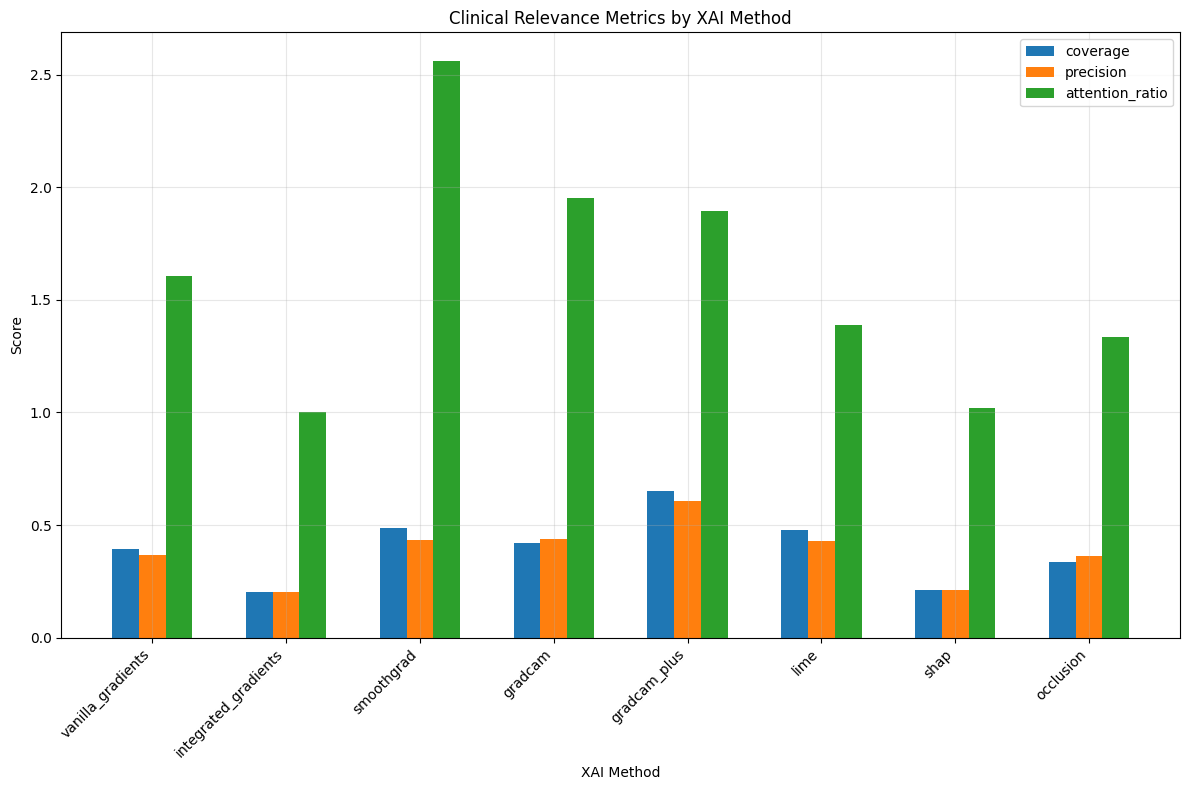

In [ ]:
print("\nPerforming clinical relevance analysis... starting now")
clinical_analyzer = ClinicalRelevanceAnalyzer()

# determine method_names robustly from all_results
if len(all_results) == 0:
    raise ValueError("all_results is empty - run XAI analysis first")

first_methods = all_results[0].get('methods') if isinstance(all_results[0], dict) else None
if not (isinstance(first_methods, dict) and len(first_methods) > 0):
    raise ValueError("Unable to infer method names from all_results[0]['methods']")

method_names = list(first_methods.keys())

# clinical relevance for each method
clinical_results = {method: [] for method in method_names}

# iterate paired with test_sample rows (keeps same ordering as earlier analysis)
for result, (_, row) in zip(all_results, test_sample.iterrows()):
    # robustly get the methods dict
    methods_dict = result.get('methods') if isinstance(result, dict) and 'methods' in result else result
    if not isinstance(methods_dict, dict):
        raise ValueError(f"Each result must contain a 'methods' dict. Problematic result: {result}")

    # load the ORIGINAL (uint8) image from disk to extract lesion mask (do NOT use preprocessed image)
    raw_img = tf.io.read_file(row['path'])
    raw_img = tf.image.decode_jpeg(raw_img, channels=3)
    raw_img = tf.image.resize(raw_img, IMAGE_SIZE)  # uses same IMAGE_SIZE as pipeline
    raw_img = tf.cast(raw_img, tf.uint8)

    lesion_mask = clinical_analyzer.extract_lesion_mask(raw_img)

    # compute focus metrics for each XAI method (skip missing heatmaps)
    for method in method_names:
        heatmap = methods_dict.get(method)
        if heatmap is None:
            # skip this method for this image (no heatmap produced)
            continue

        heatmap_arr = np.array(heatmap, dtype=np.float32)
        metrics = clinical_analyzer.compute_focus_metrics(heatmap_arr, lesion_mask)
        clinical_results[method].append(metrics)

# aggregate results safely (handle methods with zero entries)
clinical_summary = {}
for method in method_names:
    method_metrics = clinical_results.get(method, [])
    if len(method_metrics) == 0:
        clinical_summary[method] = {
            'coverage': np.nan,
            'precision': np.nan,
            'attention_ratio': np.nan
        }
    else:
        clinical_summary[method] = {
            'coverage': np.mean([m['coverage'] for m in method_metrics]),
            'precision': np.mean([m['precision'] for m in method_metrics]),
            'attention_ratio': np.mean([m['attention_ratio'] for m in method_metrics])
        }

# visualizing clinical relevance
fig, ax = plt.subplots(figsize=(12, 8))
metrics_to_plot = ['coverage', 'precision', 'attention_ratio']
x = np.arange(len(method_names))
width = 0.20
num_metrics = len(metrics_to_plot)
offset = (num_metrics - 1) / 2.0 * width

for i, metric in enumerate(metrics_to_plot):
    values = [clinical_summary[method][metric] for method in method_names]
    ax.bar(x + (i * width) - offset, values, width, label=metric)

ax.set_xlabel('XAI Method')
ax.set_ylabel('Score')
ax.set_title('Clinical Relevance Metrics by XAI Method')
ax.set_xticks(x)
ax.set_xticklabels(method_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clinical_relevance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


stats analysis

In [ ]:
from scipy import stats
import numpy as np

print("\nPerforming statistical analysis...")

# 1. Separate correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i, result in enumerate(all_results):
    if result['true_label'] == result['predicted_label']:
        correct_predictions.append(i)  # store index instead of object
    else:
        incorrect_predictions.append(i)

print(f"Correct predictions: {len(correct_predictions)}")
print(f"Incorrect predictions: {len(incorrect_predictions)}")

# 2. Compare XAI patterns between correct and incorrect predictions
if correct_predictions and incorrect_predictions:
    for method in method_names:
        correct_ratios = []
        incorrect_ratios = []

        # collect attention ratios for correct predictions
        for idx in correct_predictions:
            if idx < len(clinical_results[method]):
                ratio = clinical_results[method][idx]['attention_ratio']
                if not np.isnan(ratio):
                    correct_ratios.append(ratio)

        # collect attention ratios for incorrect predictions
        for idx in incorrect_predictions:
            if idx < len(clinical_results[method]):
                ratio = clinical_results[method][idx]['attention_ratio']
                if not np.isnan(ratio):
                    incorrect_ratios.append(ratio)

        if correct_ratios and incorrect_ratios:
            # two-sample t-test
            t_stat, p_value = stats.ttest_ind(correct_ratios, incorrect_ratios, equal_var=False, nan_policy='omit')

            print(f"\n{method}:")
            print(f"  Correct predictions - mean attention ratio: {np.mean(correct_ratios):.3f}")
            print(f"  Incorrect predictions - mean attention ratio: {np.mean(incorrect_ratios):.3f}")
            print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")



Performing statistical analysis...
Correct predictions: 15
Incorrect predictions: 5

vanilla_gradients:
  Correct predictions - mean attention ratio: 1.596
  Incorrect predictions - mean attention ratio: 1.634
  t-statistic: -0.163, p-value: 0.876

integrated_gradients:
  Correct predictions - mean attention ratio: 1.012
  Incorrect predictions - mean attention ratio: 0.965
  t-statistic: 0.428, p-value: 0.679

smoothgrad:
  Correct predictions - mean attention ratio: 2.539
  Incorrect predictions - mean attention ratio: 2.622
  t-statistic: -0.132, p-value: 0.899

gradcam:
  Correct predictions - mean attention ratio: 1.553
  Incorrect predictions - mean attention ratio: 3.145
  t-statistic: -1.939, p-value: 0.111

gradcam_plus:
  Correct predictions - mean attention ratio: 1.894
  Incorrect predictions - mean attention ratio: 1.888
  t-statistic: 0.018, p-value: 0.986

lime:
  Correct predictions - mean attention ratio: 1.323
  Incorrect predictions - mean attention ratio: 1.589
  t

Final Report

In [ ]:
# --- Report structure ---
report = {
    'metadata': {
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_samples_analyzed': len(all_results),
        'model_accuracy': float(best_model.evaluate(test_ds, verbose=0)[1]),
        'threshold_used': float(optimal_threshold)
    },
    'consistency_analysis': {
        'matrices': {metric: consistency_matrices[metric].tolist()
                     for metric in consistency_matrices},
        'method_names': method_names,
        'summary': {
            'most_consistent_pair': None,
            'least_consistent_pair': None,
            'average_consistency': {}
        }
    },
    'clinical_relevance': clinical_summary,
    'individual_results': all_results
}

# --- Compute most & least consistent pairs ---
pearson_matrix_copy = np.array(consistency_matrices['pearson'], copy=True)
np.fill_diagonal(pearson_matrix_copy, -1)  # only modify copy

max_idx = np.unravel_index(np.argmax(pearson_matrix_copy), pearson_matrix_copy.shape)
min_idx = np.unravel_index(np.argmin(pearson_matrix_copy), pearson_matrix_copy.shape)

report['consistency_analysis']['summary']['most_consistent_pair'] = {
    'methods': (method_names[max_idx[0]], method_names[max_idx[1]]),
    'correlation': float(pearson_matrix_copy[max_idx])
}

report['consistency_analysis']['summary']['least_consistent_pair'] = {
    'methods': (method_names[min_idx[0]], method_names[min_idx[1]]),
    'correlation': float(pearson_matrix_copy[min_idx])
}

# --- Average consistency per method ---
for i, method in enumerate(method_names):
    avg_consistency = np.mean([
        pearson_matrix_copy[i, j]
        for j in range(len(method_names)) if i != j
    ])
    report['consistency_analysis']['summary']['average_consistency'][method] = float(avg_consistency)

# --- Save JSON report ---
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    return obj

with open('xai_analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2, default=convert_to_serializable)

print("\nAnalysis complete! Report saved to 'xai_analysis_report.json'")



Analysis complete! Report saved to 'xai_analysis_report.json'


summary visualisation for paper

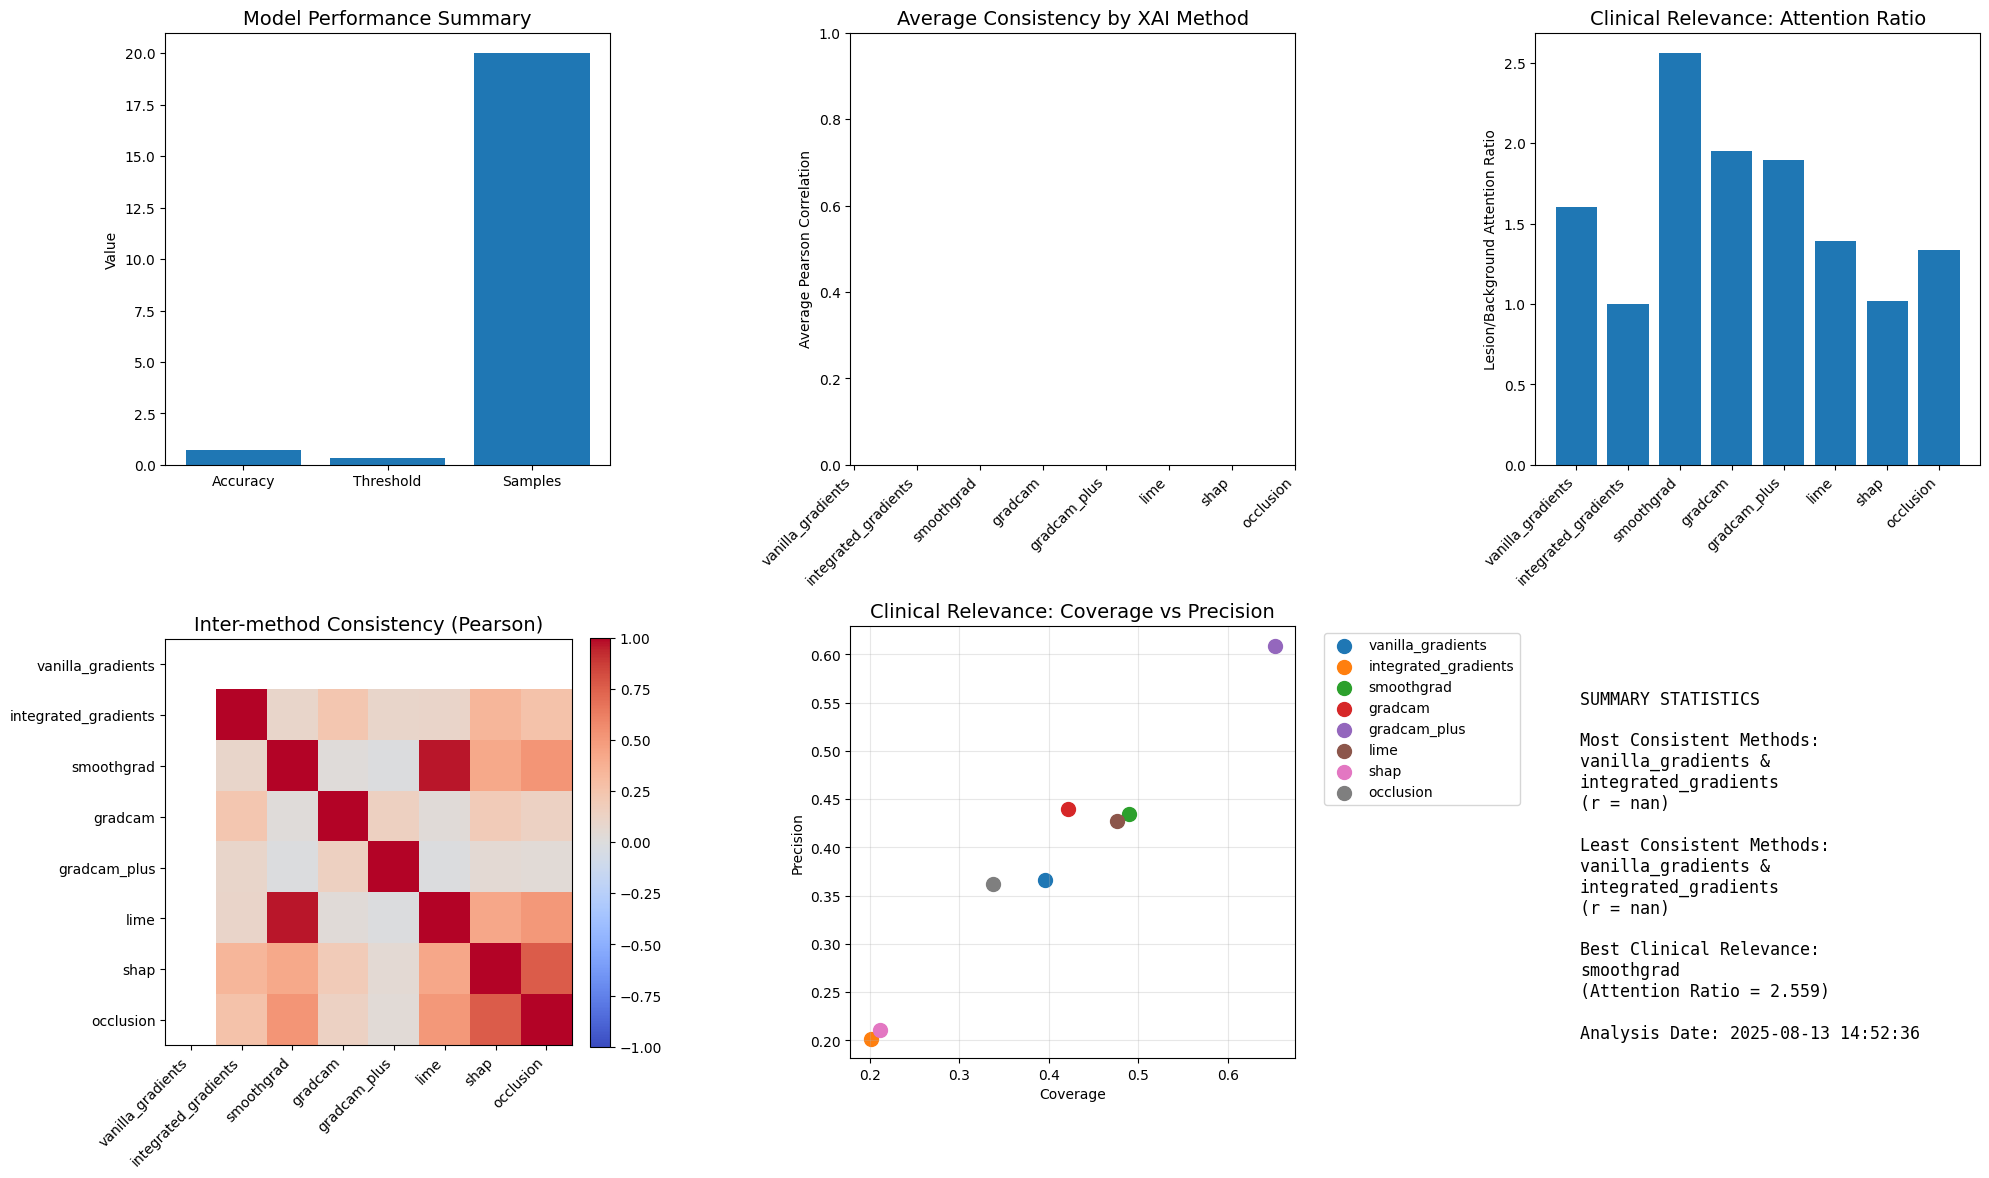

1. Individual XAI visualizations: xai_results_*.png
2. Consistency analysis: consistency_analysis.png
3. Clinical relevance analysis: clinical_relevance_analysis.png
4. Comprehensive summary: xai_comprehensive_summary.png
5. Detailed report: xai_analysis_report.json


In [ ]:
fig = plt.figure(figsize=(20, 12))

# --- 1. Model Performance Summary ---
ax1 = plt.subplot(2, 3, 1)
performance_data = {
    'Accuracy': report['metadata']['model_accuracy'],
    'Threshold': report['metadata']['threshold_used'],
    'Samples': report['metadata']['n_samples_analyzed']
}
ax1.bar(range(len(performance_data)), list(performance_data.values()))
ax1.set_xticks(range(len(performance_data)))
ax1.set_xticklabels(list(performance_data.keys()))
ax1.set_title('Model Performance Summary', fontsize=14)
ax1.set_ylabel('Value')

# --- 2. Average Consistency by Method ---
methods_consistency = list(report['consistency_analysis']['summary']['average_consistency'].keys())
consistencies = list(report['consistency_analysis']['summary']['average_consistency'].values())
ax2 = plt.subplot(2, 3, 2)
ax2.bar(range(len(methods_consistency)), consistencies)
ax2.set_xticks(range(len(methods_consistency)))
ax2.set_xticklabels(methods_consistency, rotation=45, ha='right')
ax2.set_title('Average Consistency by XAI Method', fontsize=14)
ax2.set_ylabel('Average Pearson Correlation')
ax2.set_ylim(0, 1)

# --- 3. Clinical Relevance Comparison ---
methods_clinical = list(clinical_summary.keys())
attention_ratios = [clinical_summary[m]['attention_ratio'] for m in methods_clinical]
ax3 = plt.subplot(2, 3, 3)
ax3.bar(range(len(methods_clinical)), attention_ratios)
ax3.set_xticks(range(len(methods_clinical)))
ax3.set_xticklabels(methods_clinical, rotation=45, ha='right')
ax3.set_title('Clinical Relevance: Attention Ratio', fontsize=14)
ax3.set_ylabel('Lesion/Background Attention Ratio')

# --- 4. Consistency Heatmap (Pearson) ---
ax4 = plt.subplot(2, 3, 4)
pearson_mat = np.array(consistency_matrices['pearson'])
im = ax4.imshow(pearson_mat, cmap='coolwarm', vmin=-1, vmax=1)
ax4.set_title('Inter-method Consistency (Pearson)', fontsize=14)
ax4.set_xticks(range(len(method_names)))
ax4.set_yticks(range(len(method_names)))
ax4.set_xticklabels(method_names, rotation=45, ha='right')
ax4.set_yticklabels(method_names)
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

# --- 5. Coverage vs Precision Scatter ---
ax5 = plt.subplot(2, 3, 5)
for method in methods_clinical:
    coverage = clinical_summary[method]['coverage']
    precision = clinical_summary[method]['precision']
    ax5.scatter(coverage, precision, s=100, label=method)
ax5.set_xlabel('Coverage')
ax5.set_ylabel('Precision')
ax5.set_title('Clinical Relevance: Coverage vs Precision', fontsize=14)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

# --- 6. Summary Statistics Text ---
best_clinical_method, best_clinical_vals = max(clinical_summary.items(), key=lambda x: x[1]['attention_ratio'])
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
SUMMARY STATISTICS

Most Consistent Methods:
{report['consistency_analysis']['summary']['most_consistent_pair']['methods'][0]} &
{report['consistency_analysis']['summary']['most_consistent_pair']['methods'][1]}
(r = {report['consistency_analysis']['summary']['most_consistent_pair']['correlation']:.3f})

Least Consistent Methods:
{report['consistency_analysis']['summary']['least_consistent_pair']['methods'][0]} &
{report['consistency_analysis']['summary']['least_consistent_pair']['methods'][1]}
(r = {report['consistency_analysis']['summary']['least_consistent_pair']['correlation']:.3f})

Best Clinical Relevance:
{best_clinical_method}
(Attention Ratio = {best_clinical_vals['attention_ratio']:.3f})

Analysis Date: {report['metadata']['analysis_date']}
"""
ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
         fontsize=12, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig('xai_comprehensive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("1. Individual XAI visualizations: xai_results_*.png")
print("2. Consistency analysis: consistency_analysis.png")
print("3. Clinical relevance analysis: clinical_relevance_analysis.png")
print("4. Comprehensive summary: xai_comprehensive_summary.png")
print("5. Detailed report: xai_analysis_report.json")


In [ ]:
from google.colab import files


files.download('xai_analysis_report.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>